# Exploratory Data Analysis

In this notebook I will be performing EDA on the cleaned data files that were produced in the `02_data_cleaning` notebook.
* `ticket_data_clean.pkl`
* `comments_clean.pkl`


## Import Libraries

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400

## Read Files

Pickle files were exported from the data cleaning notebook in order to preserve datatypes.

In [157]:
tickets = pd.read_pickle('../data/ticket_data_clean.pkl')
comments = pd.read_pickle('../data/comments_clean.pkl')

In [ ]:
tickets.head(3)

In [ ]:
comments.head(3)

## Tickets EDA

In [160]:
tickets.shape

(13323, 28)

In [161]:
tickets.columns

Index(['id', 'subject', 'description', 'channel', 'sat_score', 'sat_comment',
       'ticket_id', 'created', 'updtd', 'grp_stations', 'asign_stations',
       'reopens', 'replies', 'asign_updtd', 'reqstr_updtd', 'status_updtd',
       'initially_assigned', 'assigned', 'solved', 'latest_comment_added',
       'reply_mins', 'first_reso_mins', 'full_reso_mins', 'agt_wait_mins',
       'reqstr_wait_mins', 'on_hold_mins', 'sent_score', 'num_comms'],
      dtype='object')

In [162]:
tickets.dtypes

id                                    int64
subject                              object
description                          object
channel                              object
sat_score                            object
sat_comment                          object
ticket_id                             int64
created                 datetime64[ns, UTC]
updtd                   datetime64[ns, UTC]
grp_stations                          int64
asign_stations                        int64
reopens                               int64
replies                               int64
asign_updtd             datetime64[ns, UTC]
reqstr_updtd            datetime64[ns, UTC]
status_updtd            datetime64[ns, UTC]
initially_assigned      datetime64[ns, UTC]
assigned                datetime64[ns, UTC]
solved                  datetime64[ns, UTC]
latest_comment_added    datetime64[ns, UTC]
reply_mins                          float64
first_reso_mins                       int64
full_reso_mins                  

### Functions
Throughout EDA, if there are repetitive tasks identified, various functions may be written.  Including a section to house any functions written throughout EDA.

In [163]:
def dist_bound(series, stdevs):
    '''
    Takes a pandas series and a number of standard deviations and 
    returns the sum of the mean and the number of standard deviations
    specified.
    '''
    return series.mean() + (series.std() * stdevs)

### Satisfaction Score (target) Ticket Count

In [164]:
# sat_score breakdown
tickets['sat_score'].value_counts(normalize=True).mul(100).round(2)

good    85.46
bad     14.54
Name: sat_score, dtype: float64

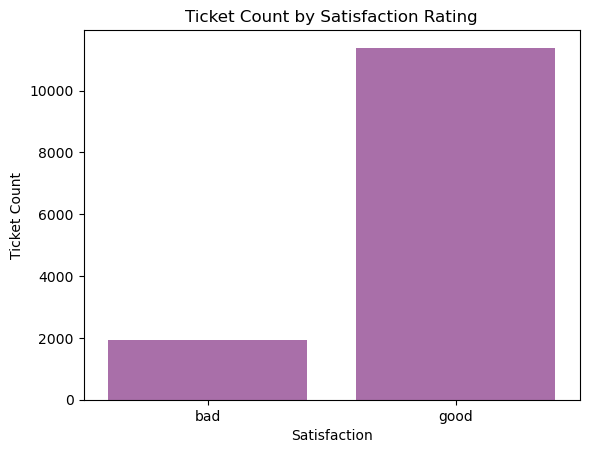

In [165]:
sns.countplot(x='sat_score', 
              data=tickets,
              palette=['purple'],
              alpha=0.6
             ).set(title='Ticket Count by Satisfaction Rating',
                   xlabel='Satisfaction',
                   ylabel='Ticket Count'
);

Good ratings are far more common than bad ratings, which is positive. This class imbalance will be something to consider going forward into modeling.  

### Ticket Channels

In [166]:
# channel breakdown
tickets['channel'].value_counts(normalize=True).mul(100).round(2)

web            66.89
email          32.95
api             0.11
help_center     0.04
mobile          0.01
Name: channel, dtype: float64

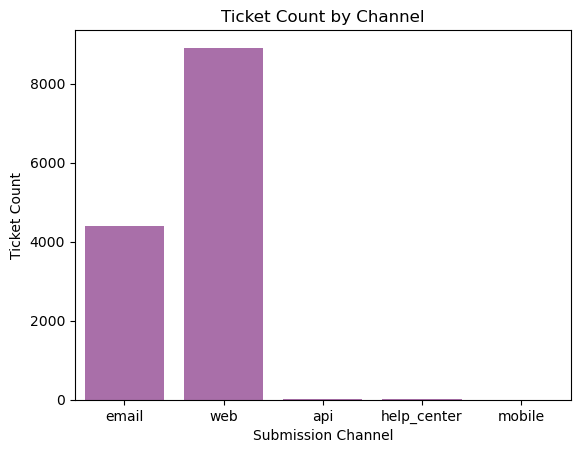

In [167]:
sns.countplot(x='channel', 
              data=tickets,
              palette=['purple'],
              alpha=0.6
             ).set(title='Ticket Count by Channel',
                   xlabel='Submission Channel',
                   ylabel='Ticket Count'
);

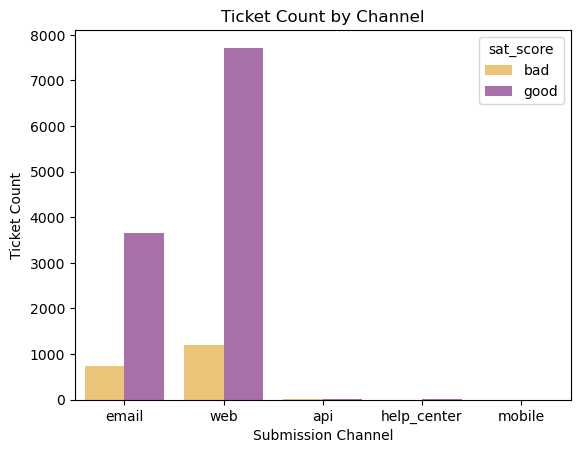

In [168]:
sns.countplot(x='channel', 
              data=tickets,
              palette=['orange','purple'],
              alpha=0.6,
              hue='sat_score'
             ).set(title='Ticket Count by Channel',
                   xlabel='Submission Channel',
                   ylabel='Ticket Count'
);

The majority of the tickets come from web (~67%), which means they were created using the online form.  Email accounts for ~33% and the other channels combined account for less than 0.16% of the tickets.

### Satisfaction Comments

This refers to the optional comments that can be left after the customer chooses the rating.

In [169]:
# sat_comments
tickets['sat_comment'].nunique() / tickets.shape[0]

0.3103655332882984

About 31% of the rated tickets have a satisfaction comment.

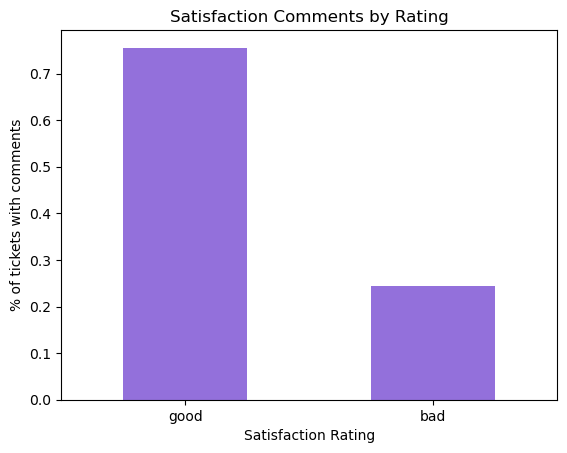

In [170]:
(tickets
 .query('~sat_comment.isna()')
 ['sat_score']
 .value_counts(normalize=True)
).plot(kind='bar',
       rot=0,
       color='mediumpurple',
       title='Satisfaction Comments by Rating',
       ylabel='% of tickets with comments',
       xlabel='Satisfaction Rating'
       );

It is interesting that the customers leaving comments are doing so more often on tickets they are rating as Good.  Often people talk about how much louder angry customers are, so you may have expected that of rated tickets that leaving comments the majority might be ones where a Bad rating was indicated.  It is a higher percentage than overall distribution of good and bad ratings, so it does align with the idea that customers that indicate a bad rating tend to leave comments at a higher rate.

#### Examples

In [ ]:
# maybe retrieve some examples of comments from good and bad
(
    tickets
    .query(f'sat_score == "bad"')
    .dropna()
    .sample(5)
    [['sat_comment']]
)

In [172]:
# maybe retrieve some examples of comments from good and bad
(
    tickets
    .query(f'sat_score == "good"')
    .dropna()
    .sample(5)
    [['sat_comment']]
)

,sat_comment
12204,Thank you for the continued support and quick reply
7507,Quick response and my question was answered to my satisfaction.
4700,Very helpful and we get the problem solved. Thanks!
2226,Thanks Brandon for your assistance!\r\n\r\nDon
8812,"Thank you, Lyndon! \r\nYour expert support is always at the highest level. \r\nBrightSign is lucky to have you.\r\nDragan"


It looks like these comments largely map to the good and bad ratings indicated.

### Sentiment

Let's examine the sentiment scores that we calculated for tickets. 

In [173]:
tickets['sent_score'].describe()

count    13323.000000
mean         0.488628
std          0.267261
min         -0.975850
25%          0.325095
50%          0.507200
75%          0.687813
max          0.999700
Name: sent_score, dtype: float64

These values look like they are in the -1 to 1 range that we would expect.

Mean/average is .48 and median is 0.50 which is fairly positive (if the low end of positive is .05).  Median is right around the mean and the standard deviation leads me to believe this will be approaching normally distributed but have a negative skew.

In [174]:
tickets['sent_score'].skew()

-0.6470311020319603

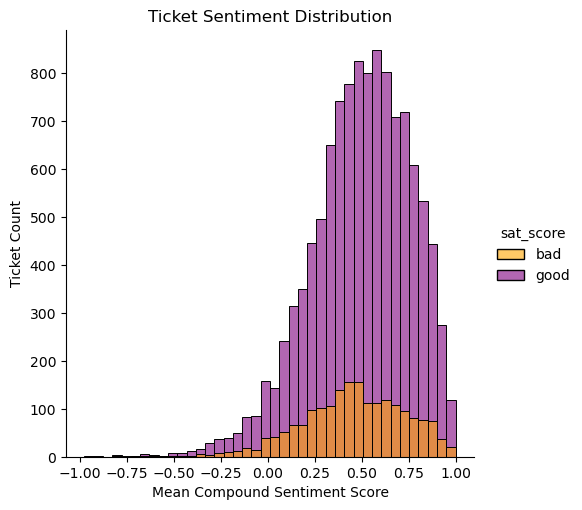

In [185]:
sns.displot(data=tickets,
            x='sent_score',
            hue='sat_score',
            bins=40,
            palette=['orange','purple'],
            alpha=0.6).set(title='Ticket Sentiment Distribution',
                           xlabel='Mean Compound Sentiment Score',
                           ylabel='Ticket Count'
                          );

In the above plot, you can see that this is approaching a normal distribution shape, but does have a negative skew.  The majority of the ticket sentiment scores are neutral or positive--the scoring reference from the VADER documentation states:
* positive sentiment: compound score >= 0.05
* neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
* negative sentiment: compound score <= -0.

It does look like the tickets with a 'bad' rating peak slightly lower on the score scale, but still quite positive as far as the sentiment score.

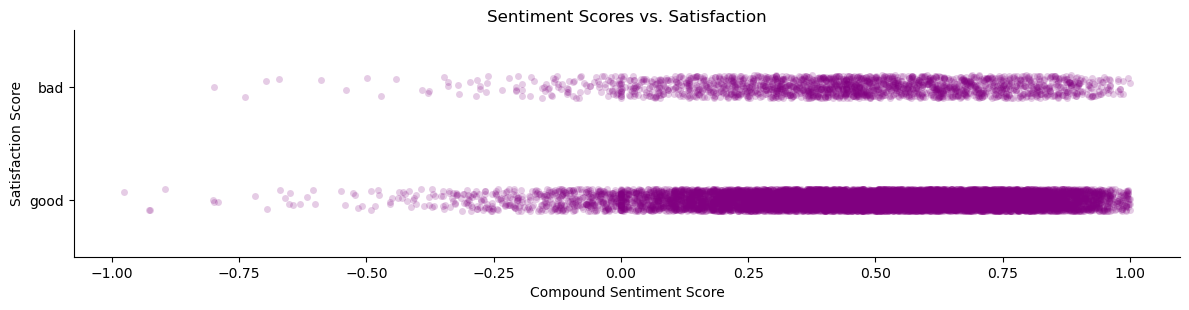

In [201]:
sns.catplot(data=tickets,
            x='sent_score',
            y='sat_score', 
            alpha=0.2,
            color='purple',
            height=3,
            aspect=4
           ).set(title='Sentiment Scores vs. Satisfaction',
                 xlabel='Compound Sentiment Score',
                 ylabel='Satisfaction Score'
                );

This is another way to look at the same data.  I've increased the transparency of the data points, so the darker areas would show higher concentrations of values. As observed in the histogram, you can see the small concentration of scores just below the .50 range, when looking at the bad satisfaction scores.  You can also see that both good and bad tickets span almost the entire score range.

### Counts Features
Some of the features in this data speak to counts of certain activites:
* `grp_stations` - Number of groups the ticket passed through
* `asign_stations` - Number of assignees the ticket had
* `reopens` - Total number of times the ticket was reopened
* `replies` - The number of public replies added to a ticket by an agent
* `num_comms` - Number of comments on the ticket. This was calculated when comment sentiment was generated. Possible this is similar to `replies`

Becuase these are all counts, the analysis might be similar, so putting them in this section together.

In [94]:
counts = ['grp_stations', 
          'asign_stations',
          'reopens', 
          'replies',
          'num_comms'
         ]

tickets[counts].describe()

,grp_stations,asign_stations,reopens,replies,num_comms
count,13323.000000,13323.000000,13323.000000,13323.000000,13323.000000
mean,1.078961,1.068828,0.286947,2.684606,6.431810
std,0.512487,0.331262,0.581582,3.146151,7.662315
min,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,0.000000,1.000000,2.000000
50%,1.000000,1.000000,0.000000,2.000000,4.000000
75%,1.000000,1.000000,0.000000,3.000000,8.000000
max,21.000000,10.000000,7.000000,122.000000,270.000000


There are some interesting observations here:
* **Group Stations**
    * The majority of the rated tickets were only with 1 group
    * However, there is at least one ticket that changed group 21 times
* **Assignee Stations**
    * Like group stations, the majority of these rated tickets only had 1 assignee
    * The most times a rated ticket was re-assigned to another agent was 10
* **Reopens**
    * Of rated tickets, most tickets are not re-opened
    * Most was re-opened 7 times.  This happens when a ticket moves to closed (by agent or rule) but then the customer replies to re-open the ticket
* **Replies**
    * Interesting that at least 1 ticket has no replies, but still has a rating
    * Rated tickets have, on average, 2.7 replies and the median is 3 replies
    * One of the rated tickets has 122 replies!
* **Number of Comments**
    * Different from replies, this would include all comments, public and private, from a ticket.
    * Average of 6.4 comments with median of 4 comments
    * It makes sense that the values in this feature are higher than replies, due to the inclusion of all comments.
    * Outpacing replies, the maximum number of comments on a rated ticket is 270.
    
    
So a typical ticket that is rated:
* Submitted through the web form
* Only belong to one internal group/team
* Have 1 assignee
* Are not re-opened
* Have 2 replies sent to the customer
* Have a total of 4 comments

In [95]:
tickets[counts].skew()

grp_stations      18.945174
asign_stations     8.361930
reopens            2.496461
replies            8.786935
num_comms          9.494816
dtype: float64

All these distributions have a positive skew, which was also indicated from the descriptive statistics having median values all lower than the means. Looking at the distributions of these counts, separated by satisfaction score to see if there are any major differences that could be spotted:    

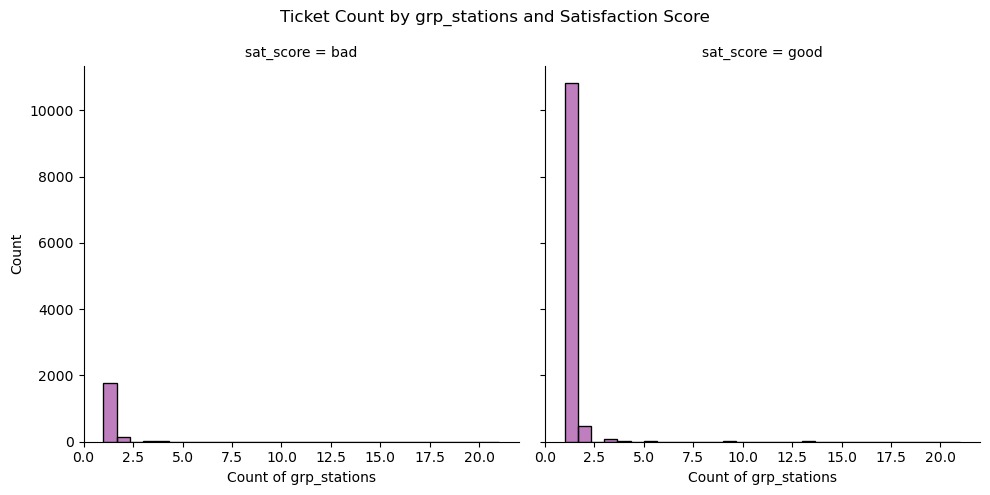

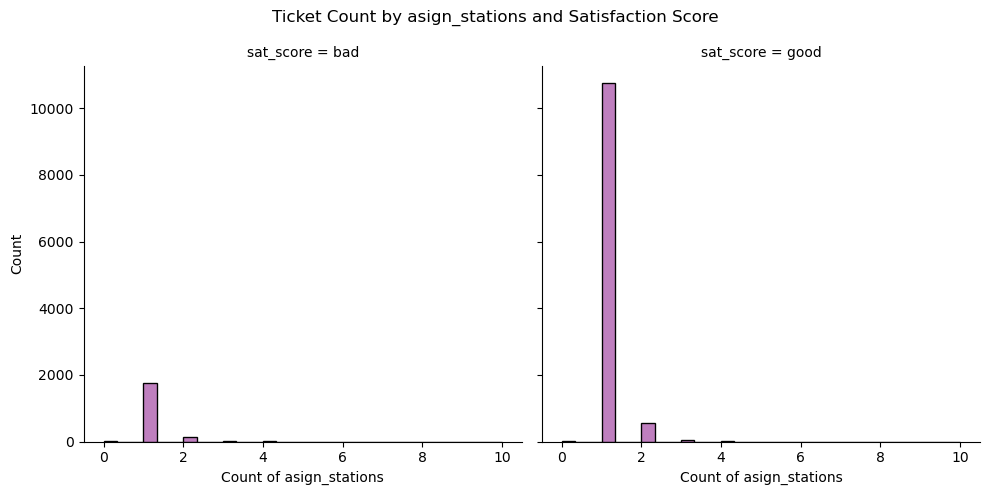

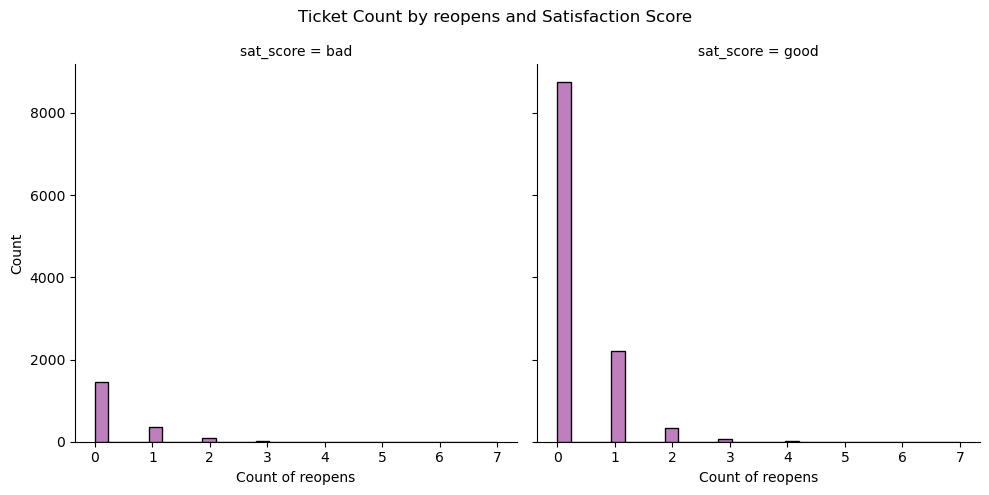

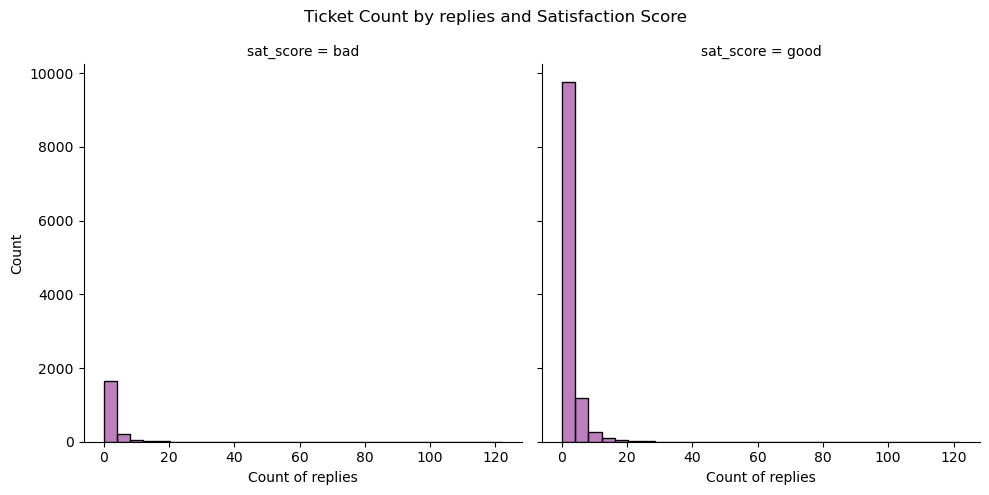

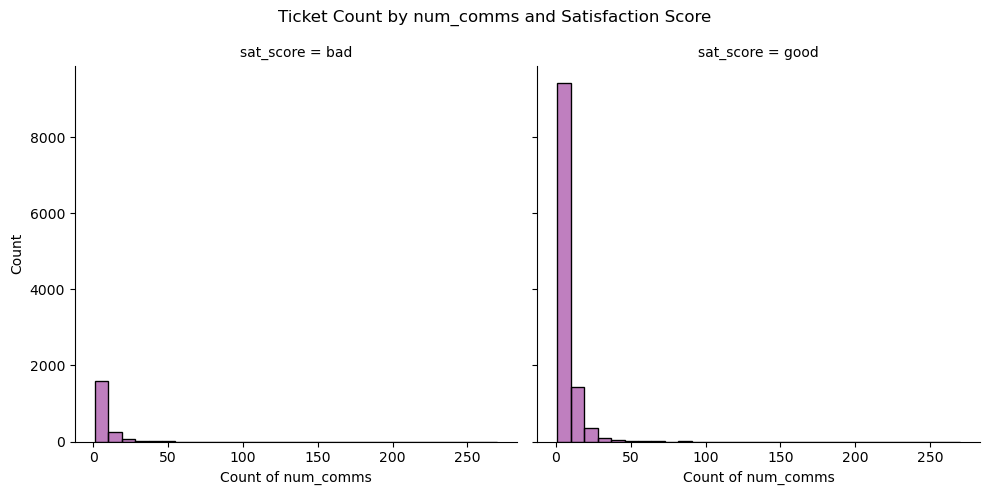

In [96]:
# create plots for all the count features
for count in counts:
    sns.displot(data=tickets,
                x=count,
                col='sat_score',
                kind='hist',
                bins=30,
                color='purple',
                alpha=0.5
               ).set(xlabel=f'Count of {count}'
                    )
    plt.suptitle(f'Ticket Count by {count} and Satisfaction Score')
    plt.tight_layout();

The distributions are so centered on particular values, that it makes seeing specifics difficult, but also means that there might not be anything particularly interesting to find here.  In looking throught the distributions above that are broken out by the satisfaction score, the magnitudes are different, which is to be expected given the class imbalance, but the shapes are very similar.

### Minute Counts

Like the above count features, there are also a number of features that record the number of minutes for certain actions:

* `reply_mins` - Number of minutes to the first reply during calendar and business hours
* `first_reso_mins` - Number of minutes to the first resolution time during calendar and business hours
* `full_reso_mins` - Number of minutes to the full resolution during calendar and business hours
* `agt_wait_mins` - Number of minutes the agent spent waiting during calendar and business hours
* `reqstr_wait_mins` - Number of minutes the requester spent waiting during calendar and business hours
* `on_hold_mins` - Number of minutes on hold

In [97]:
min_counts = ['reply_mins', 'first_reso_mins', 'full_reso_mins', 
              'agt_wait_mins', 'reqstr_wait_mins', 'on_hold_mins']

In [98]:
tickets[min_counts].describe()

,reply_mins,first_reso_mins,full_reso_mins,agt_wait_mins,reqstr_wait_mins,on_hold_mins
count,13323.000000,1.332300e+04,1.332300e+04,13323.000000,1.332300e+04,1.332300e+04
mean,1380.416648,1.693274e+04,2.218217e+04,5350.052541,1.656972e+04,3.501747e+03
std,9926.571312,6.160425e+04,7.632308e+04,8926.392130,7.541863e+04,5.080692e+04
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,67.000000,7.830000e+02,1.389000e+03,4.000000,2.190000e+02,0.000000e+00
50%,209.000000,7.310000e+03,7.454000e+03,3870.000000,9.320000e+02,0.000000e+00
75%,564.000000,9.953000e+03,1.302100e+04,7276.000000,4.355000e+03,0.000000e+00
max,409608.000000,2.253693e+06,2.286965e+06,234467.000000,2.286886e+06,2.189366e+06


In [99]:
tickets[min_counts].skew()

reply_mins          20.638915
first_reso_mins     16.021027
full_reso_mins      13.209235
agt_wait_mins        8.023215
reqstr_wait_mins    13.568798
on_hold_mins        28.651496
dtype: float64

First impression in looking at these descriptive statistics, makes it look like they have high means, and large standard deviations, but relatively (to the mean) low median and IQR values.  That would indicate that these values aren't closely clustered around the mean and are quite spread out.  

As an example, `reply_mins` is the number of minutes before the first reply.  Often support metrics are measured in hours, so that could explain some of the higher values, but a max of >409k translates to 284 days, so it's very possible that is an outlier.  I'll need to look at each of these features and try to identify what might be considered an outlier for each and what impact filtering the data to handle those might be.

Here the average ticket (minutes in calendar minutes, not business):
* First reply in 1380 (mean) / 209 (median) minutes 
* Resolution in 22182 (mean) / 7454 (median) minutes
* Agent waits 5350 (mean) 3870 / (median) minutes 
* Requester waits 16569 (mean) / 932 (median) minutes

#### First Reply Time Dive

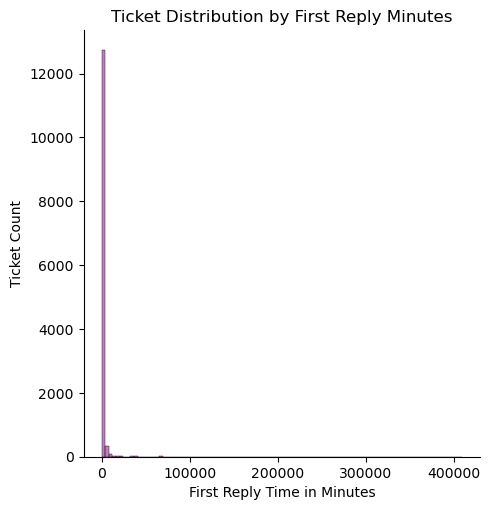

In [100]:
sns.displot(data=tickets,
            x='reply_mins',
            kind='hist',
            bins=100,
            color='purple',
            alpha=0.5
           ).set(title='Ticket Distribution by First Reply Minutes',
                 xlabel='First Reply Time in Minutes',
                 ylabel='Ticket Count'
);

The distribution of these values has a large positive (right) skew.  With the default histogram settings it's clear that the largest concentration is in low values, especially with this bin count of 100, but then there are other values stretching all the way to over 400,000.  It's a bit difficult to see what is going on here.  I'll try and adjust the x and y axis limits to see if I can get a better view.

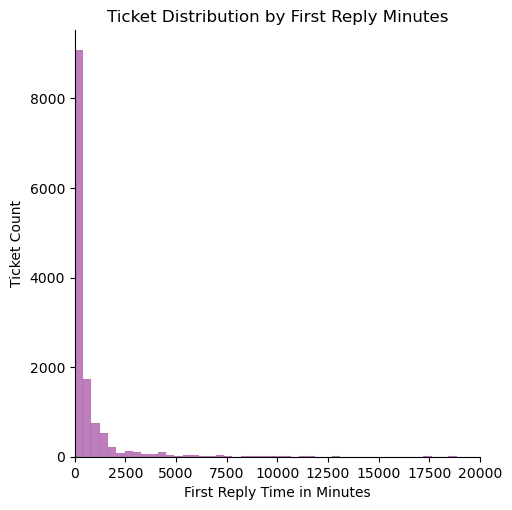

In [101]:
sns.displot(data=tickets,
            x='reply_mins',
            kind='hist',
            bins=1000,
            # hue='sat_score',
            color='purple',
            alpha=0.5            
           ).set(title='Ticket Distribution by First Reply Minutes',
                 xlabel='First Reply Time in Minutes',
                 ylabel='Ticket Count',
                 xlim=(0,20_000)
);

In the above plot, the X-axis has been limited to 20,000 which is a little lower than two standard deviations beyond the mean.  Even with this restriction, and a large bin count of 1000, it's apparent that there are small values of tickets that create this very long right-skew tail, and most of the values are under 2500 minutes.

#### Resolution Time Dive

Resolution time is another metric that is commonly used in various customer-facing roles, that can be used as a measure of efficiency, so this feature will also be looked at a bit more carefully.

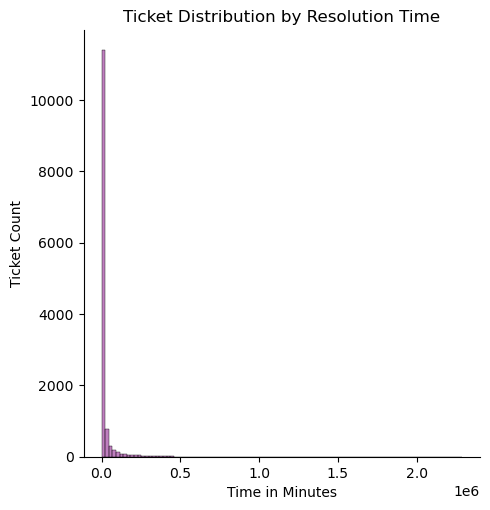

In [102]:
sns.displot(data=tickets,
            x='full_reso_mins',
            kind='hist',
            bins=100,
            color='purple',
            alpha=0.5
           ).set(title='Ticket Distribution by Resolution Time',
                 xlabel='Time in Minutes',
                 ylabel='Ticket Count'
);

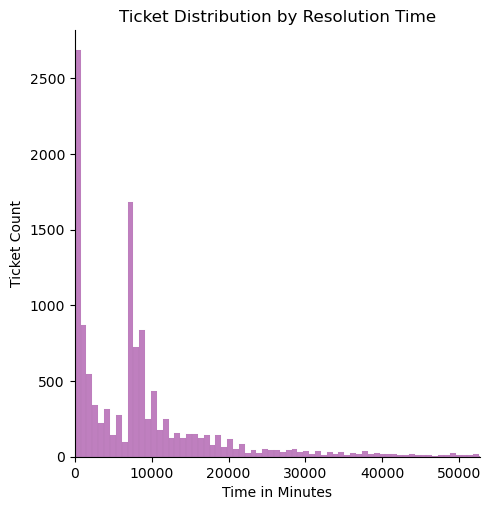

In [103]:
# cycled through some various boundaries like 3 standard deviations, but
# this lower value provided some additional resolution that seemed interesting

sns.displot(
    tickets['full_reso_mins'],
    kind='hist',
    bins=3000,
    color='purple',
    alpha=0.5
).set(
    title='Ticket Distribution by Resolution Time',
    xlabel='Time in Minutes',
    ylabel='Ticket Count',
    xlim=(0, dist_bound(tickets['full_reso_mins'], .4))
);

In the above plot the count of bins is much larger than the initial plot, plus the X-axis is only showing from 0 to the mean + .4 Standard Deviations, but this has revealed a bit of bi-modal distribution.  After 20,000 minutes it appears the case count tapers off, but there is consistent, low amounts of activity throughout the tail of this distribution.

All of the tickets from the Zendesk system are part of this dataset, and there are multiple teams that utilize this system with different response profiles, so this could account for some of this activity.  Given that we only have just over 13k rows, careful consideration of how to identify and treat outliers will need to be kept in mind for modeling.  There could be some valuable information contained in these observations, but an approach to handling these values may be needed.

I expect that the rest of the plots for the remaining minute count features will look similar, so I'll programatically plot them.

#### Other Minute Counts

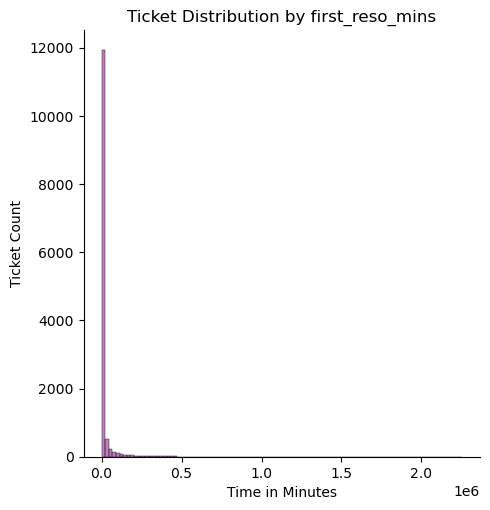

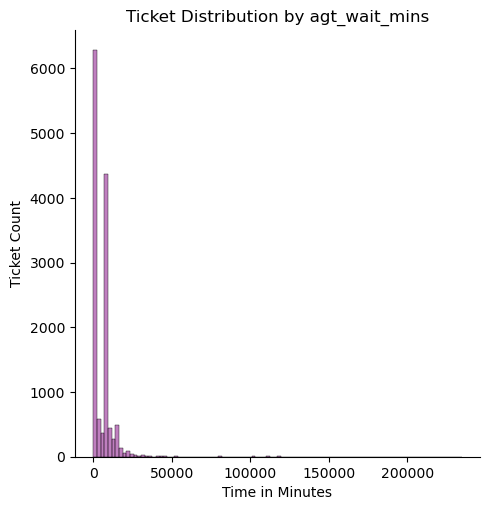

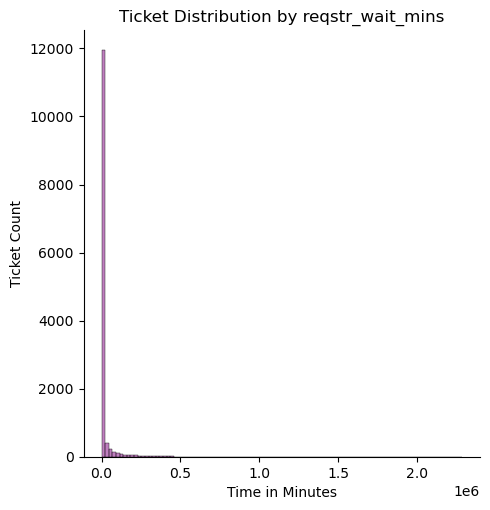

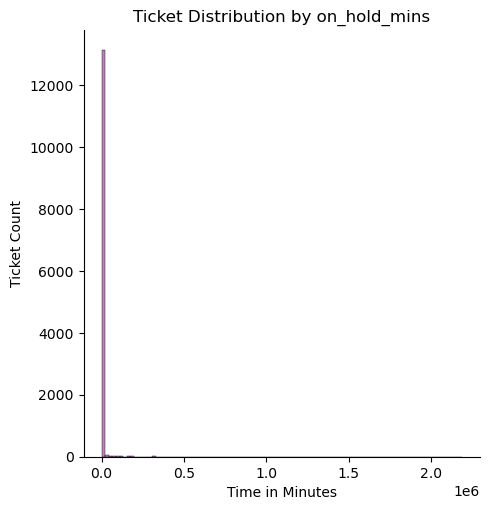

In [104]:
for count in min_counts:
    if count not in ['reply_mins', 'full_reso_mins']:
        sns.displot(data=tickets,
            x=count,
            kind='hist',
            bins=100,
            color='purple',
            alpha=0.5                    
           ).set(title=f'Ticket Distribution by {count}',
                 xlabel=f'Time in Minutes',
                 ylabel='Ticket Count'
);

As suspected, most of these distributions appear similar in shape with high concentrations of values at the extreme low end and long right-skew tails. The exception is the agent wait times which appears to have a bimodal distribution, so I'll look at that more closely below.  As noted with the reply_time feature, these minute counts should all be under consideration for treatment of outliers, but significant data loss could occur depend on the method.  Given that there isn't a lot of data here, I'm hesitant to remove data.

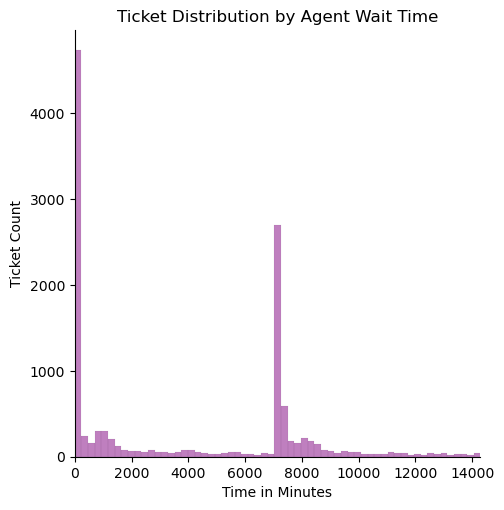

In [105]:
sns.displot(
    tickets['agt_wait_mins'],
    kind='hist',
    bins=1000,
    color='purple',
    alpha=0.5
).set(
    title='Ticket Distribution by Agent Wait Time',
    xlabel='Time in Minutes',
    ylabel='Ticket Count',
    xlim=(0, dist_bound(tickets['agt_wait_mins'], 1))
);

Similar to what was seen in the resolution time distribution, we see two very clear concentration of values.  This feature represents the number of minutes the agent spent waiting, meaning when the ticket is updated into 'pending' status and is waiting for a reply from the customer, this timer would increment.  When the customer replies to the ticket the counter would pause.

I understand the lowest concentration since that most likely represents "one-touch" tickets where the ticket is solved on first reply.  The second mode is around ~7000 minutes, which works out to almost 5 days.  From what I recall, there are various time-based rules for tickets.  Meaning, if the agent sends a reply, this would put a ticket in pending status and start the timer.  If the customer does not reply, there is a reminder email sent, then later another email is sent and the ticket is set to solved.  This action and the notification that the ticket has been solved can certainly elicit reaction or response from customers.  I believe that is likely the cause for the shape of the distribution we're seeing.

### Subject and Description Length

On any given ticket that is submitted, the subject is like the subject of an email and is meant to be a short description of the ticket when the ticket is submitted through the web form.  When the ticket is submitted by email, this is the actual subject from the email.

Description is the more detailed description of the issue/request, or the body of the email if submitted via email.  

In [106]:
tickets['sub_len'] = tickets['subject'].str.len()
tickets['desc_len'] = tickets['description'].str.len()

Descriptive stats

In [107]:
tickets[['sub_len', 'desc_len']].describe()

,sub_len,desc_len
count,13323.000000,13323.00000
mean,33.439315,743.81228
std,19.703728,1766.08587
min,1.000000,0.00000
25%,19.000000,239.00000
50%,29.000000,423.00000
75%,43.000000,760.00000
max,213.000000,64035.00000


In [108]:
tickets[['sub_len', 'desc_len']].skew()

sub_len      1.466078
desc_len    17.563947
dtype: float64

The subject length has a smaller range than most of the other features that have been examined thus far.  It is also much less skewed than other features, but the median is still lower than the mean, so it still has a positive skew.  The range is fairly small and the standard deviation isn't that large, so I would suspect that this distribution is approaching normal.

Description length is much more like most of the other features with a very large range, a relatively large standard deviation, and a median value that is much lower than the mean.  So the data distribution also has a large positive right-skew with a long tail.

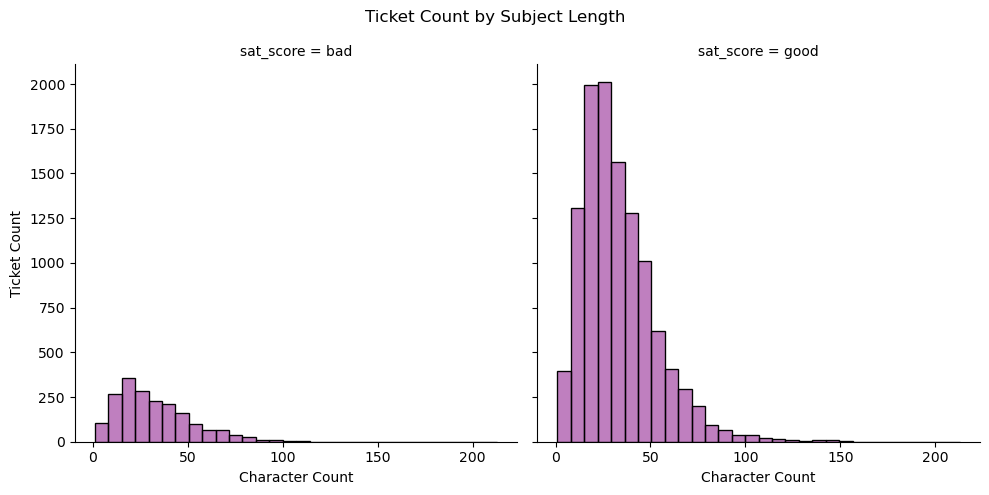

In [109]:
sns.displot(data=tickets,
            x='sub_len',
            kind='hist',
            bins=30,
            col='sat_score',
            color='purple',
            alpha=0.5            
           ).set(xlabel='Character Count',
                 ylabel='Ticket Count'
                )
plt.suptitle('Ticket Count by Subject Length')
plt.tight_layout();

This plot is showing the subject length distribution which is the most normally distributed feature that has been seen yet.  It still has a right tail, but certainly not on the order of what has been seen so far.  Overall, it makes sense that email subjects, and short descriptions on the web form aren't too lengthy.  Like we've seen throughout many of the features, the shapes are very similar between the good and the bad, but the class imbalance is impacting the magnitudes.

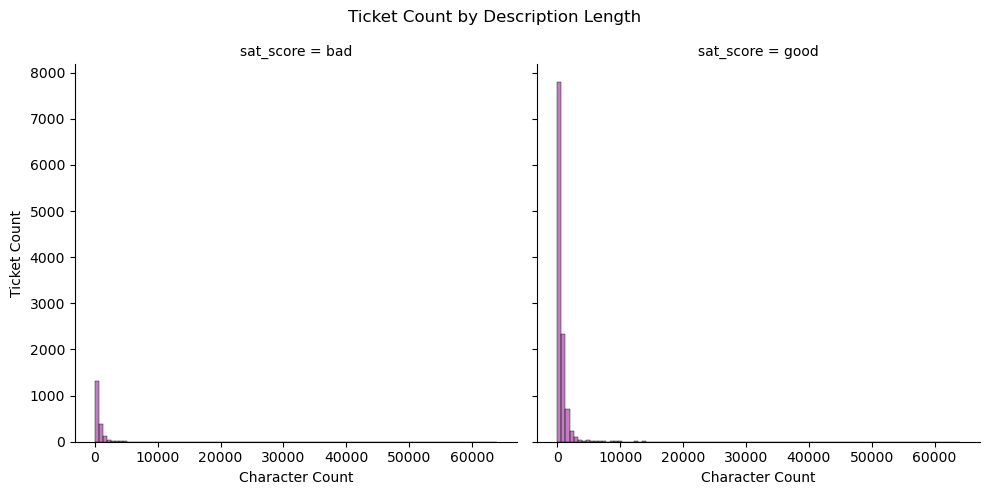

In [110]:
sns.displot(data=tickets,
            x='desc_len',
            kind='hist',
            bins=100,
            col='sat_score',
            color='purple',
            alpha=0.5            
           ).set(xlabel='Character Count',
                 ylabel='Ticket Count'
                )

plt.suptitle('Ticket Count by Description Length')
plt.tight_layout();

This description length distribution is more in line with the majority of the features that have been examined.  A high concentration at low values and a high positive skew with a long right tail.  The range seen here is understandable as customers have all sorts of communication styles--meaning some provide many details about what they need help with, while others may just say "help" or "call me".

As above, the shapes are very similar between the good and the bad, but the class imbalance is impacting the magnitudes.

### Ticket Time Components

When we queried the Zendesk APIs to retrieve this data, the ticket metric data contained many fields that held timestamp information. The following features are timestamps:
* `created` - When the record was created
* `updtd` - When the record was last updated
* `asign_updtd` - When the assignee last updated the ticket
* `reqstr_updtd` - When the requester last updated the ticket
* `status_updtd` - When the status of the ticket was last updated
* `initially_assigned` - When the ticket was initially assigned
* `assigned` - When the ticket was assigned
* `solved` - When the ticket was solved
* `latest_comment_added` - When the latest comment was added

As I'm exploring the dataset, some high-level timeseries information will be good to look at.  From the data we have, it would be good to look at:
* Tickets created over time
* Tickets solved over time
* Ticket sentiment over time

Since I'm looking at these over time, they are mainly to identify if there are any trends of note in these areas.  

In [111]:
time_cols = ['created', 'updtd', 'asign_updtd', 'reqstr_updtd', 
             'status_updtd', 'initially_assigned', 'assigned', 
             'solved', 'latest_comment_added']

#### Tickets Created Over Time

In [112]:
tickets['created'].min(), tickets['created'].max()

(Timestamp('2016-05-31 07:17:16+0000', tz='UTC'),
 Timestamp('2023-01-18 21:57:41+0000', tz='UTC'))

The tickets in the dataset range from being created the end of May 2016 to Jan 18, 2023, which is close to when I started to gather the ticket data through the API.

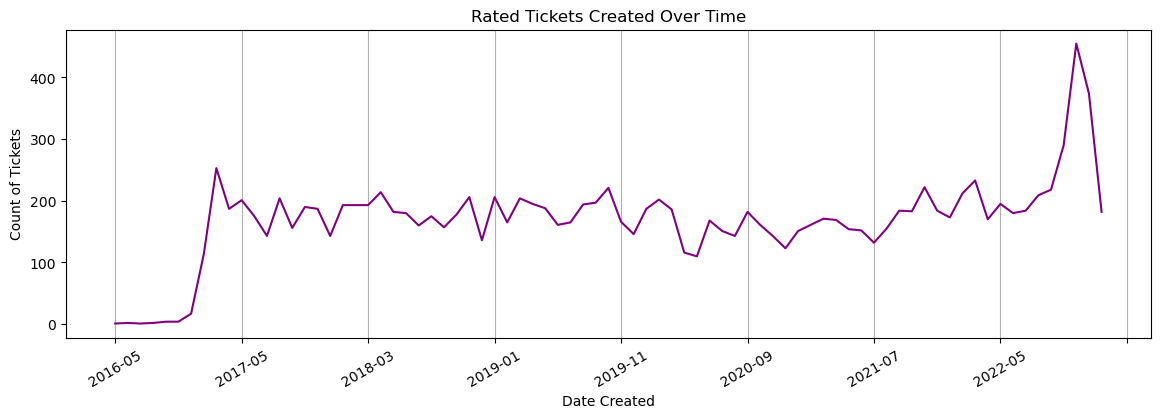

In [113]:
fig, axs = plt.subplots(figsize=(14, 4))

(
    tickets
    .groupby(
        tickets['created']
        .dt.strftime('%Y-%m')
    )
    ['id']
    .count()
    .plot(
        kind='line',
        color='purple',
        rot=30,
        ax=axs,
        title='Rated Tickets Created Over Time',
        xlabel='Date Created',
        ylabel='Count of Tickets'
    )
)

axs.xaxis.grid(True)
plt.locator_params(axis='x', nbins=15)

The above plot is showing rated tickets by creation date over time.  The very low volume tickets early on, with the quick ramp up is most likely due to satisfaction surveys not being enabled, and then once enabled, some of the longer standing tickets, when closed, would have been surveyed.  Over the timespan that is observed here, the rated ticket volume is a little lumpy, but fairly consisten until the end of 2022, where there is a sharp increase.  I'm not sure what would contribute to that, but I will raise this with the business to try and find out.

#### Tickets Solved Over Time

In [114]:
tickets['solved'].min(), tickets['solved'].max()

(Timestamp('2017-02-21 09:26:14+0000', tz='UTC'),
 Timestamp('2023-01-19 01:21:01+0000', tz='UTC'))

Looking at the solved timestamp range compared to the created timestamp range aligns with what was mentioned above.  The solved date of the first rated ticket was not until February 2017, but created in May of 2016.  So that would explain the created date plot especially the ramp up in volume in the early 2017 time range.

Plot tickets solved over time

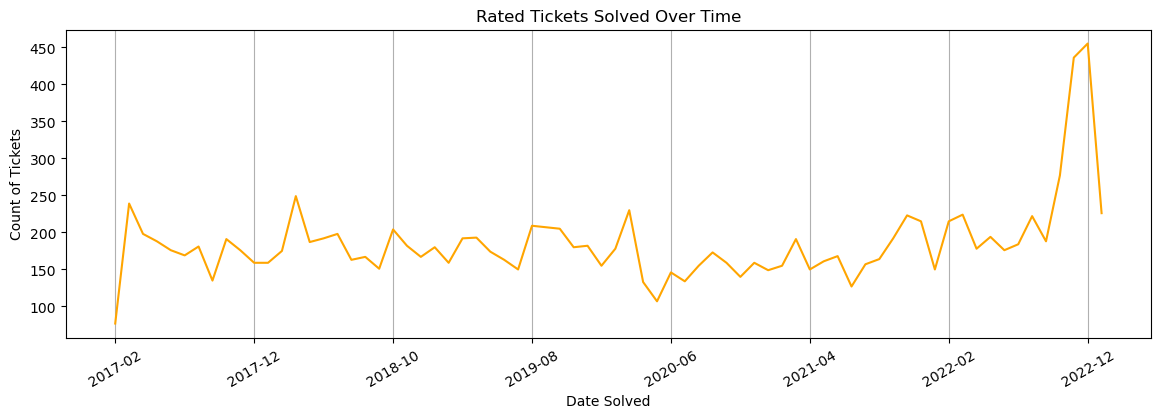

In [115]:
fig, axs = plt.subplots(figsize=(14, 4))

(
    tickets
    .groupby(
        tickets['solved']
        .dt.strftime('%Y-%m')
    )
    ['id']
    .count()
    .plot(
        kind='line',
        color='orange',
        rot=30,
        ax=axs,
        title='Rated Tickets Solved Over Time',
        xlabel='Date Solved',
        ylabel='Count of Tickets'       
    )
)

axs.xaxis.grid(True)
plt.locator_params(axis='x', nbins=14)

Compared to the ticket created plot, this plot has a very similar shape, which indicates that tickets are rated in fairly consistent mannder--meaning no huge differences from when surveys are issued and when they are rated.  At a high level this was expected, but it was good to see the beginning timestamp differences between the created and solved dates.

#### Ticket Sentiment Over Time

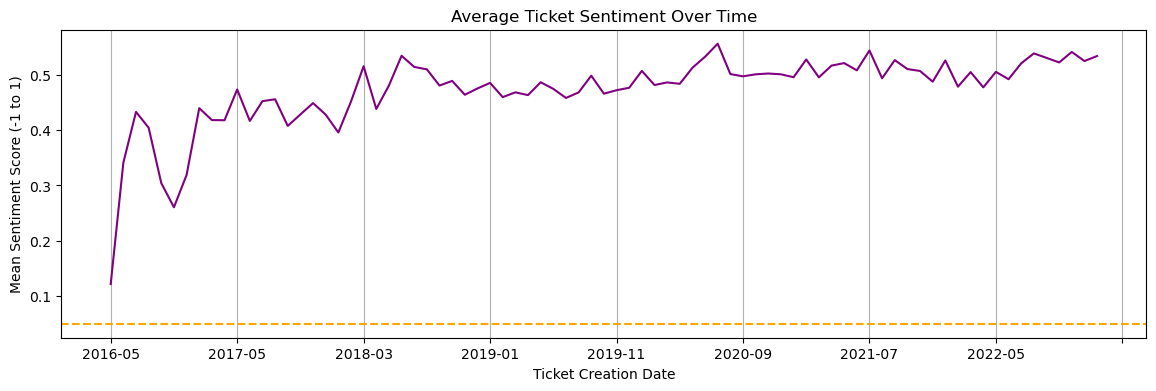

In [116]:
fig, axs = plt.subplots(figsize=(14, 4))

(
    tickets
    .groupby(
        tickets['created']
        .dt.strftime('%Y-%m')
    )
    ['sent_score']
    .mean()
    .plot(
        kind='line',
        color='purple',
        title='Average Ticket Sentiment Over Time',
        xlabel='Ticket Creation Date',
        ylabel='Mean Sentiment Score (-1 to 1)'
    )
)
axs.xaxis.grid(True)
plt.axhline(y=0.05, color='orange', linestyle='dashed')
plt.locator_params(axis='x', nbins=15)

The above plot is showing the ticket sentiment over time, with ticket sentiment being calculated by taking the mean of the compound sentiment scores of all the comments from the ticket.  The sentiment score scale goes from -1 to 1, so the overall sentiment of the tickets from this company are very positive.  The VADER sentiment [analysis documentation](https://github.com/cjhutto/vaderSentiment#about-the-scoring) states the following ranges in regards to scoring:
* positive sentiment: compound score >= 0.05
* neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
* negative sentiment: compound score <= -0.

The orange line on the plot indicates the 0.05 line described in the documentation.

Overall it appears that there is a slightly positive trend in the score over time.

#### Minute Counts Over Time

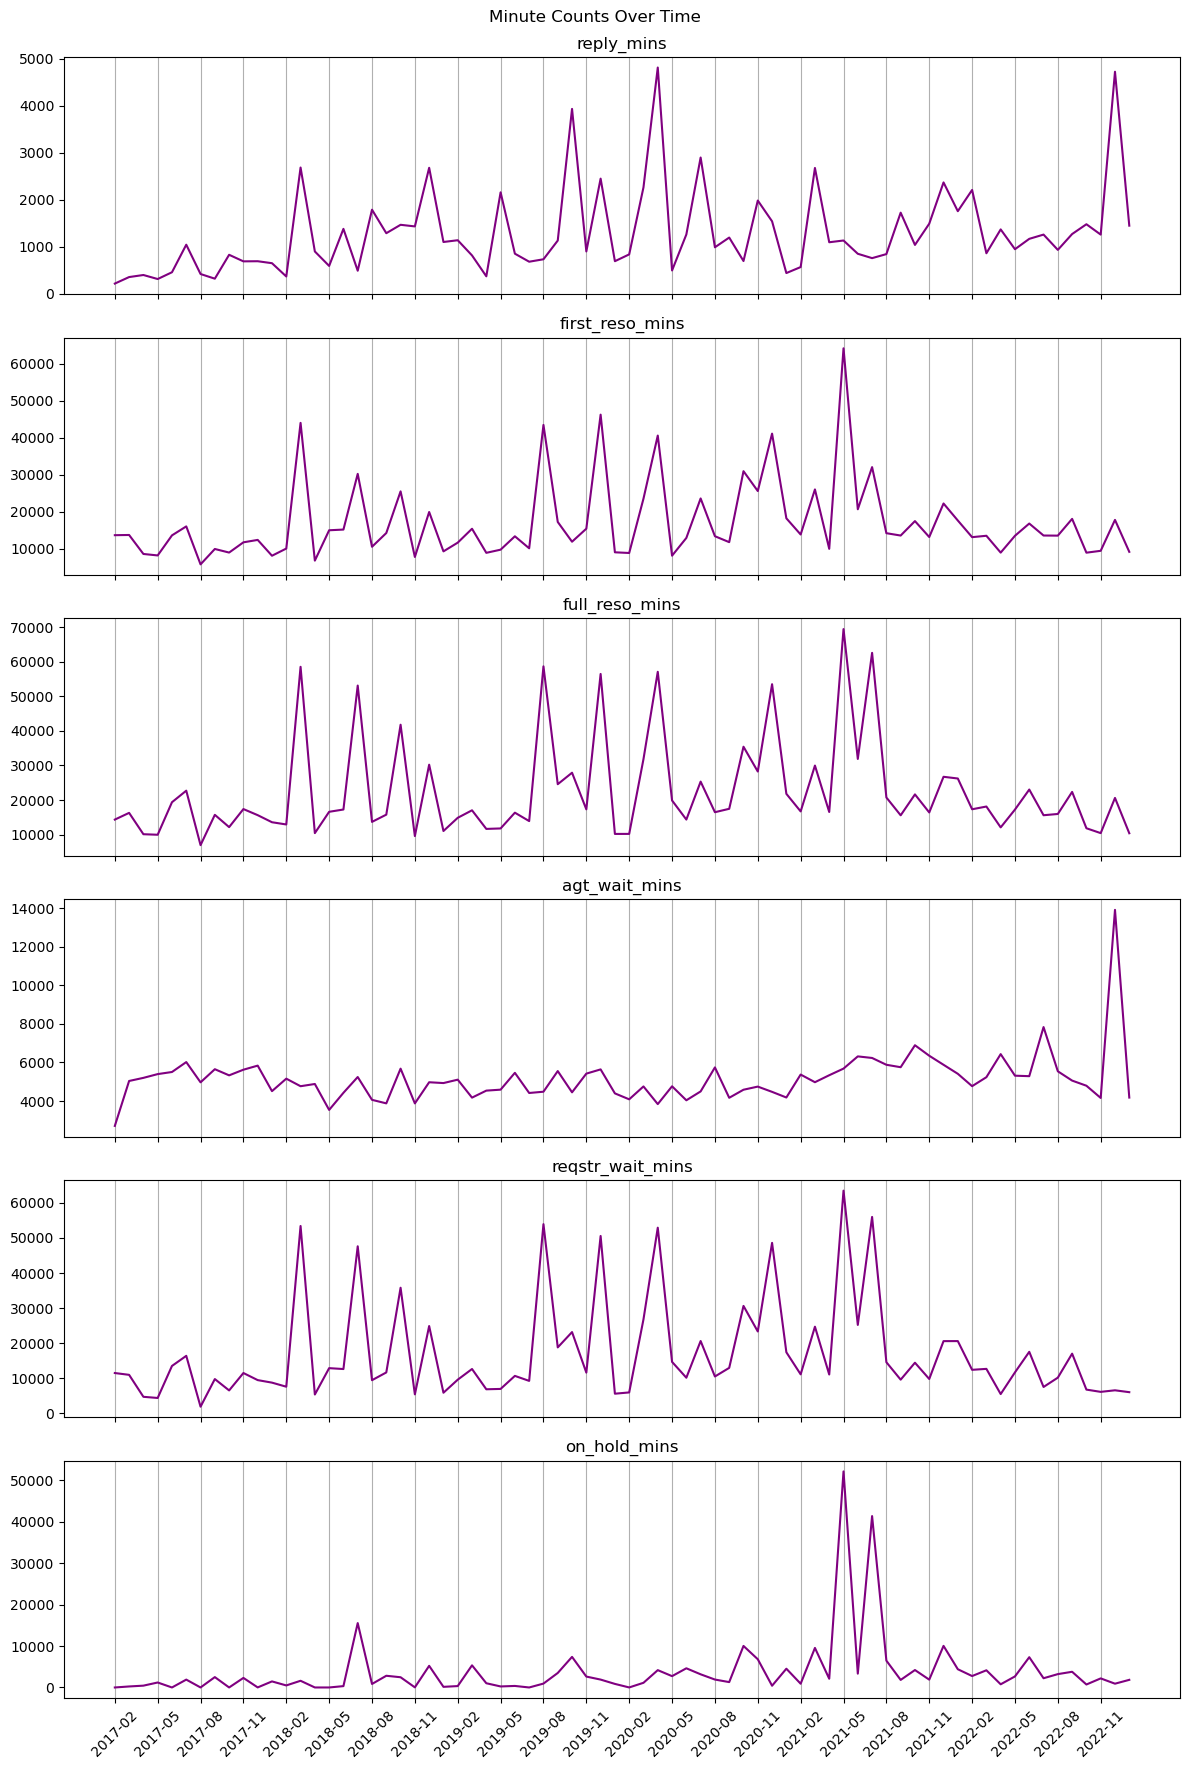

In [117]:
fig, axs = plt.subplots(6, 1, figsize=(12, 18), sharex=True)


min_count_plot = (
    tickets
    .groupby(
        tickets['solved']
        .dt.strftime('%Y-%m')
    )
    .agg({
        'reply_mins': 'mean',
        'first_reso_mins': 'mean',
        'full_reso_mins': 'mean',
        'agt_wait_mins': 'mean',
        'reqstr_wait_mins': 'mean',
        'on_hold_mins': 'mean'
    })

)

for ax, col in enumerate(min_count_plot.columns):
    axs[ax].plot(min_count_plot.index, 
                 min_count_plot[col],
                 color='purple')
    axs[ax].set_title(f'{col}')
    axs[ax].xaxis.grid(True)

axs[5].set_xticks(axs[5].get_xticks()[::3])
plt.xticks(rotation=45)
# axs.xaxis.grid(True)
plt.suptitle('Minute Counts Over Time\n');
plt.tight_layout()

It is interesting looking across all these different minute counts over time, where there are clearly some relationships between first resolution, full resolution, and requester wait times--they all have similar peaks.  The other interesting element of these is that there are months where some of the values are drastically different than other months, yet the overall ticket creation, solved, and sentiment over time is much more consistent.

This information would likely be interesting to the management team to see if they had some additional insights as to specific events or challenges that would lead to some of the spikes that are observed in these plots.

### Feature Correlation

Now that I have looked through the features, and created some new ones to explore, let's look to see how these features may or may not be correlated to the target and/or each other.

In [118]:
# change target to a numeric value
tickets['sat_score'] = tickets['sat_score'].map({'good': 1,
                                                 'bad': 0})

In [119]:
# remove id and ticket_id numeric fields as they aren't metrics or 
# descriptive to the target or other features

(
    tickets
    .drop(columns=[
        'id',
        'ticket_id'
    ])
    .corr(numeric_only=True)
)

,sat_score,grp_stations,asign_stations,reopens,replies,reply_mins,first_reso_mins,full_reso_mins,agt_wait_mins,reqstr_wait_mins,on_hold_mins,sent_score,num_comms,sub_len,desc_len
sat_score,1.000000,-0.032847,-0.044149,-0.031189,-0.007643,-0.063995,-0.062720,-0.086792,-0.057140,-0.079902,-0.017481,0.052570,-0.005880,0.016146,-0.008129
grp_stations,-0.032847,1.000000,0.677203,0.038314,0.079646,0.012721,0.045297,0.043306,0.045563,0.037871,0.025157,0.037063,0.089360,-0.002157,0.030173
asign_stations,-0.044149,0.677203,1.000000,0.078264,0.160126,0.015424,0.103730,0.096723,0.085081,0.087005,0.063126,0.000497,0.168420,0.019449,0.023581
reopens,-0.031189,0.038314,0.078264,1.000000,0.278298,-0.014603,-0.030768,0.121456,0.172285,0.095441,0.030349,-0.002172,0.282722,0.004648,0.013825
replies,-0.007643,0.079646,0.160126,0.278298,1.000000,-0.050857,0.189637,0.266799,0.204845,0.243219,0.065164,-0.074322,0.960413,0.051964,0.042164
reply_mins,-0.063995,0.012721,0.015424,-0.014603,-0.050857,1.000000,0.146992,0.141394,0.022845,0.140398,0.011527,0.021130,-0.024153,0.046911,0.064241
first_reso_mins,-0.062720,0.045297,0.103730,-0.030768,0.189637,0.146992,1.000000,0.841771,0.098251,0.840358,0.674118,-0.051871,0.195080,0.075794,0.057581
full_reso_mins,-0.086792,0.043306,0.096723,0.121456,0.266799,0.141394,0.841771,1.000000,0.147737,0.992838,0.731364,-0.055256,0.273932,0.076573,0.059543
agt_wait_mins,-0.057140,0.045563,0.085081,0.172285,0.204845,0.022845,0.098251,0.147737,1.000000,0.029052,0.004411,-0.048994,0.184560,-0.008307,-0.002211
reqstr_wait_mins,-0.079902,0.037871,0.087005,0.095441,0.243219,0.140398,0.840358,0.992838,0.029052,1.000000,0.739099,-0.050024,0.252850,0.078455,0.060478


Look at just the correlation to the target feature

In [120]:
(
    tickets
    .drop(columns=[
        'id',
        'ticket_id'
    ])
    .corr(numeric_only=True)
    ['sat_score']
    .sort_values()
)

full_reso_mins     -0.086792
reqstr_wait_mins   -0.079902
reply_mins         -0.063995
first_reso_mins    -0.062720
agt_wait_mins      -0.057140
asign_stations     -0.044149
grp_stations       -0.032847
reopens            -0.031189
on_hold_mins       -0.017481
desc_len           -0.008129
replies            -0.007643
num_comms          -0.005880
sub_len             0.016146
sent_score          0.052570
sat_score           1.000000
Name: sat_score, dtype: float64

Since the correlation table above is very difficult to decipher, I'll plot a heatmap to check for correlation between features, or any other useful insights that might be gleaned.

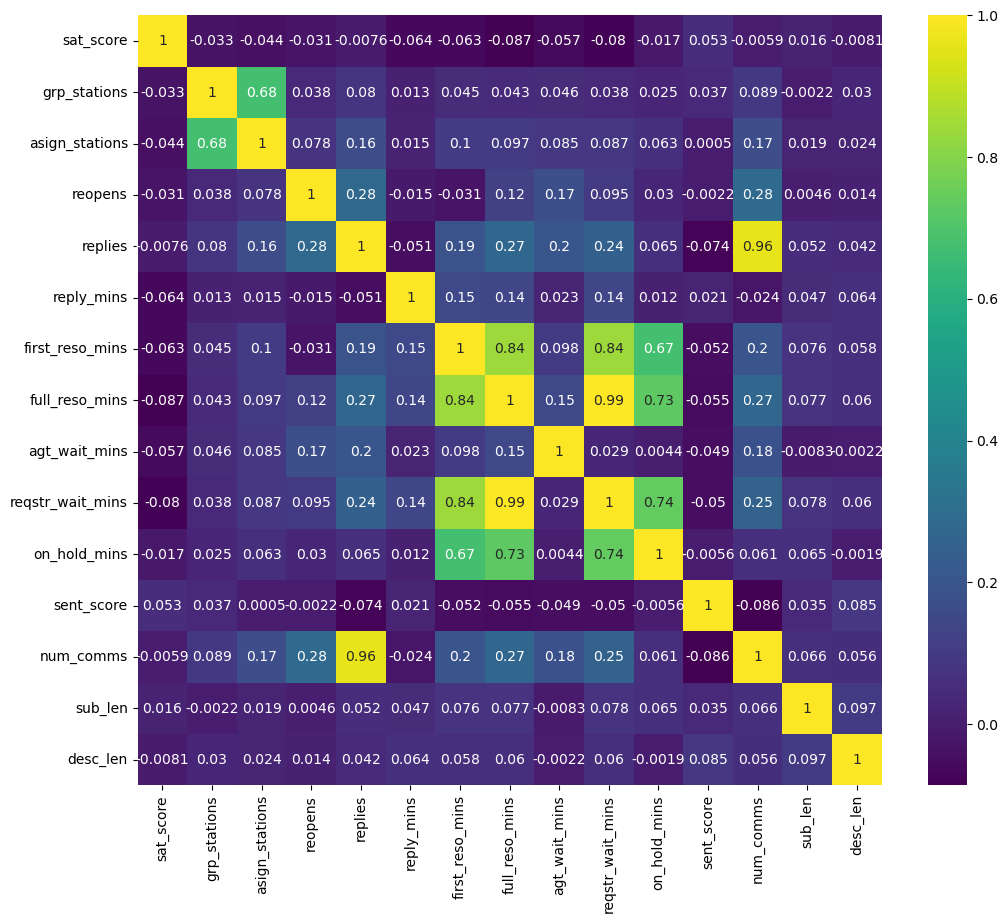

In [121]:
plt.figure(figsize=(12,10))

sns.heatmap(
    (
        tickets
        .drop(columns=[
            'id',
            'ticket_id'
        ])
        .corr(numeric_only=True)
    ),
    cmap='viridis',
    annot=True
);

Looking at both the correlation matrix as well as the heatmap, there doesn't seem to be any strong correlations either positive or negative, to the target.  

There is some correlation between certain features, especially:
* `replies` and `num_comms` (0.96)
* `reqstr_wait_mins` and `full_reso_mins` (0.99)

This should be kept in mind before modeling, as it's likely only one feature from each of those pairs should be chosen.

I'll plot the features with the 2 highest and lowest correlations

* `full_reso_mins     -0.086792`
* `reqstr_wait_mins   -0.079902`
* `sub_len             0.016146`
* `sent_score          0.052570`


#### Visualizations for Correlated Features
For the top and bottom 2 features identified above, let's plot these so they can be visualized.

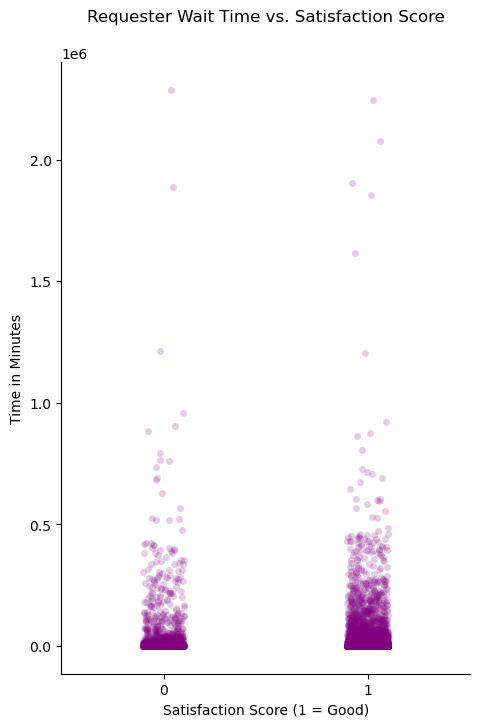

In [122]:
sns.catplot(data=tickets,
            y='reqstr_wait_mins',
            x='sat_score',
            color='purple',
            alpha=0.2,
            height=7,
            aspect=.7
           ).set(title='Requester Wait Time vs. Satisfaction Score\n',
                 ylabel='Time in Minutes',
                 xlabel='Satisfaction Score (1 = Good)'
                );

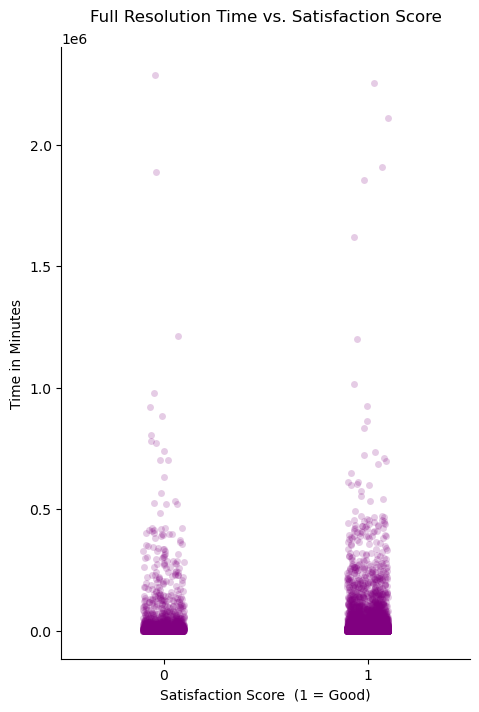

In [123]:
sns.catplot(data=tickets,
            y='full_reso_mins',
            x='sat_score',
            color='purple',
            alpha=0.2,
            height=7,
            aspect=.7
           ).set(title='Full Resolution Time vs. Satisfaction Score\n',
                 ylabel='Time in Minutes',
                 xlabel='Satisfaction Score  (1 = Good)'
                );

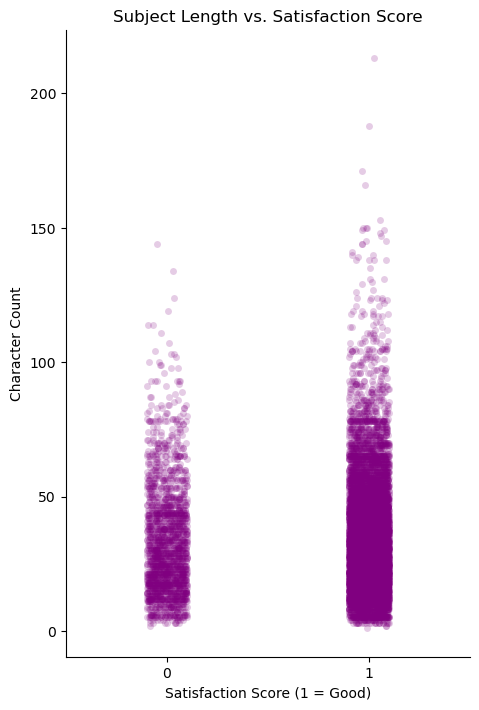

In [124]:
sns.catplot(data=tickets,
            y='sub_len',
            x='sat_score',
            color='purple',
            alpha=0.2,
            height=7,
            aspect=.7
           ).set(title='Subject Length vs. Satisfaction Score',
                 ylabel='Character Count',
                 xlabel='Satisfaction Score (1 = Good)',
                );

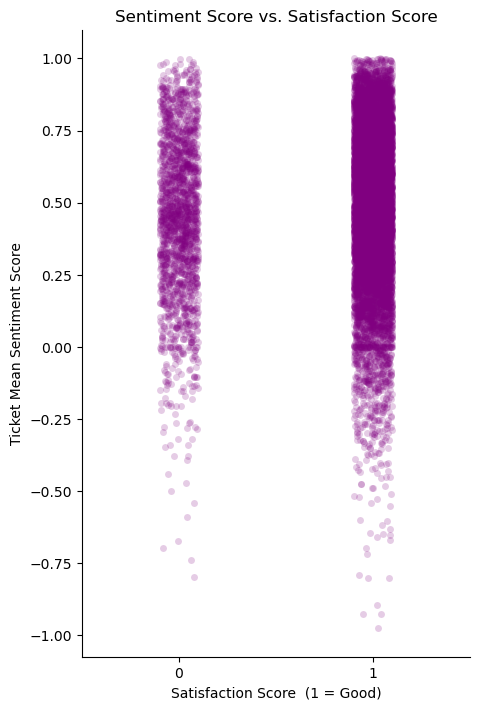

In [125]:
sns.catplot(data=tickets,
            y='sent_score',
            x='sat_score',
            color='purple',
            alpha=0.2,
            height=7,
            aspect=.7
           ).set(title='Sentiment Score vs. Satisfaction Score',
                 ylabel='Ticket Mean Sentiment Score',
                 xlabel='Satisfaction Score  (1 = Good)',
                 # yticks=[0,1],
                 # xlim=(0, 500000)
                );

The four plots above don't show strong differentiation between the plotted features and the target class.  I increased the transparency so the darker areas do show higher concentration of observations. This is representing some of the distributions we examined earier, and corroborate what was seen there--large concentration of values in certain areas, and similar shapes of data between the good and bad satisfaction scores.  Given the imbalance in the class, it may be difficult to visualize any nuance in these plots.   This appears like it will be a challenge in modeling, so this will need to be kept in mind going forward.

In [126]:
tickets.shape

(13323, 30)

In [127]:
tickets.isna().sum()[tickets.isna().sum() > 0]

sat_comment    9035
dtype: int64

## Comments EDA

In [128]:
comments.shape

(85691, 7)

In [129]:
comments.columns

Index(['author_id', 'plain_body', 'public', 'created_at', 'channel',
       'ticket_id', 'sent_score'],
      dtype='object')

### Length

In [133]:
comments['len'] = comments['plain_body'].str.len()

In [134]:
comments['len'].describe()

count    85691.000000
mean       538.549883
std       1109.684807
min          0.000000
25%        174.000000
50%        332.000000
75%        611.000000
max      64481.000000
Name: len, dtype: float64

In [135]:
comments['len'].skew()

21.178707545061844

The range of character counts of comments ranges quite a bit, from 0 characters to over 64k.  These counts could be impacted by some of the cleaning that occurred, where elements like URLs and emails were removed, but should be comparable to each other.  The mean is higher than the median value, so this distribution is most likely shaped like many of the other features we've examined, with a long tail, right-skewed.

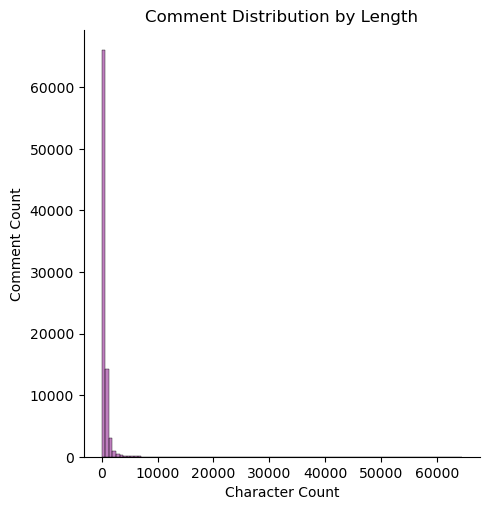

In [136]:
sns.displot(data=comments,
            x='len',
            kind='hist',
            bins=100,
            color='purple',
            alpha=0.5
           ).set(title='Comment Distribution by Length',
                 xlabel='Character Count',
                 ylabel='Comment Count'
);

As thought, this looks much like many of the other distributions we've seen so far, with the high concentration of values in lower values, and long right tails.  I'll limit the X-axis to try and get a little bit better look at this.

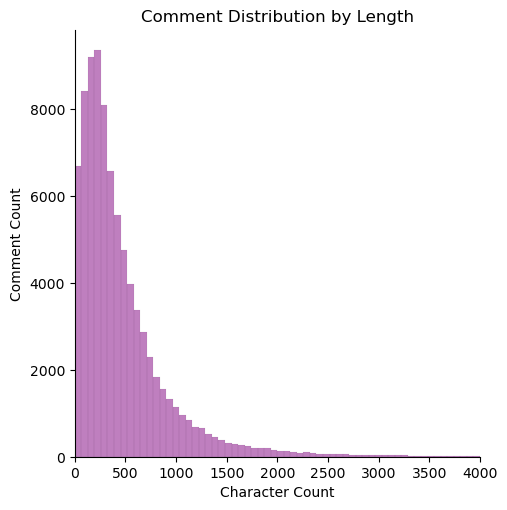

In [155]:
sns.displot(data=comments,
            x='len',
            kind='hist',
            bins=1000,
            color='purple',
            alpha=0.5
           ).set(title='Comment Distribution by Length',
                 xlabel='Character Count',
                 ylabel='Comment Count',
                 xlim=(0, 4_000)
);

In the above plot, I've restricted the X-axis to 4000 which is approximately the mean + 3 standard deviations.  The bin count was also increased to see a bit more granularity here.  The majority of the values are close to the median (332) and the values taper off just over 2000 characters.

In [138]:
# show mean, max, and median lengths for public vs. private comments
(
    comments
    .groupby('public')
    .agg({
        'len': ['mean', 'max', 'median']
    })
)

len              
              mean    max median
public                          
False   412.554409  30040  111.0
True    547.725781  64481  343.0

Looking at the comment length by visibility (public/private) we can see that internal comments tend to be about 3x shorter, on average, than public comments.  Both are lower than the overall average comment length, but the average public comment lenght (343) is very close to the overall median (332).

In [139]:
# show mean, max, and median lengths for comments by channel
(
    comments
    .groupby('channel')
    .agg({
        'len': ['mean', 'max', 'median'],
        'ticket_id': 'count'
    })
    .sort_values(by=('ticket_id', 'count'), ascending=False)
)

len               ticket_id
                   mean    max median     count
channel                                        
web          440.117002  62170  304.0     53751
email        707.810205  64481  378.0     29553
mobile       587.728358   4979  534.0      1675
system       863.993443  14291  534.5       610
api          624.072165   6228  402.0        97
help_center  443.600000   1054  334.0         5

The table above looks at comment length by channel the comment was created.  From the ticket analysis, we know that web and email are the top channels by a large margin.  This is a slightly different, as this is looking at the comment channel and not the ticket channel. It would be possible for a ticket to be created in one channel and have comments coming for other channels, depending on how the ticket is updated.

It is interesting that web and email both have similar maximums, however, the mean of email comments lenghts are about 61% larger than mean web comments.  This could be explained by things like email signatures that may appear in emails but would not necessarily appear in customer submitted comments through the ticketing web interface.

The mobile data is interesting in that it has higher mean and median values, but these comments come from employees using the Zendesk mobile app, which could explain why these values are above average in length.

### Sentiment

As the comment sentiment was calculated in the previous notebook, it may be interesting to view some of the comments associated with the highest and lowest sentiment scores.

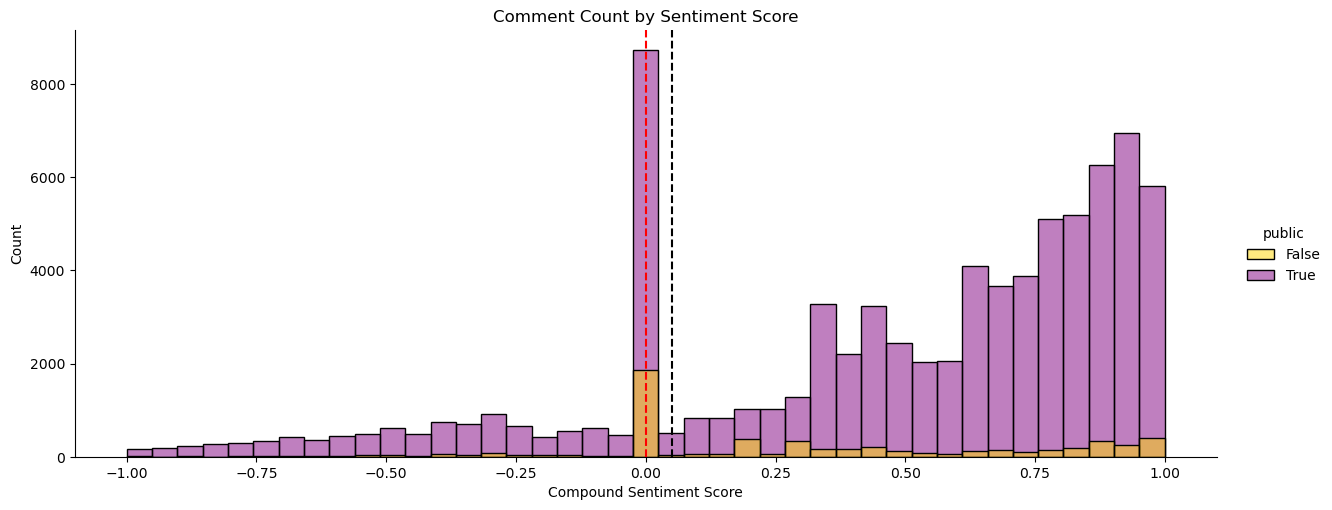

In [140]:
sns.displot(data=comments,
            x='sent_score',
            hue='public',
            bins=41,
            palette=['gold', 'purple'],
            aspect=2.5
           ).set(title='Comment Count by Sentiment Score',
                 xlabel='Compound Sentiment Score')

# plot line for lower range of positive
plt.axvline(0.05, linestyle='dashed', color='black')

# plot line for upper range of negative
plt.axvline(0, linestyle='dashed', color='red');

Above, you can see the count of comments by compound sentiment score (VADER).  The red vertical line at 0 is the boundary which below is considered negative sentiment.  Between the red line and black line are the neutral sentiments, which means that above the black vertical line are positive sentiment comments.  There is a large concentration of neutral sentiment comments that appears to be about 10% of the total comment data we have.  The majority of the comments in this data have a positive sentiment, and tend towards the higher end of positive sentiments as well.

Also, in this chart you can see that the people that are leaving internal comments rarely use language that is classified as negative--almost all the internal comments are neutral sentiment or higher.

### Sentiment Examples

Here, I will try and pull out some examples of positive and negative sentiment comments.  Since we know that some of the comments can be quite lengthy, I'll filter the data to look for comments that are shorter in length so we can read them.

NOTE: I also adjusted the length to try and mask obvious personal information from these comments, like phone numbers.

In [141]:
def print_body(df, index_vals, col='plain_body'):
    '''
    Takes df, column name, and list of index values and prints out the value 
    of the column (default='plain_body'.
    '''
    for i in index_vals:
        print('------------------')
        print(f'Comment index {i}. Sentiment Score: {df.loc[i,"sent_score"]}\n')
        print(df.loc[i,col])
        print('------------------')
    

In [ ]:
# print out the 5 most negative comments with length under 600 characters
print_body(comments,
                    (
                        comments
                        .query('len < 600')
                        .sort_values(by='sent_score')
                        .head()
                        .index
                    )
          )

In [ ]:
# print out the 5 most positive comments with length under 600 characters
print_body(comments,
                    (
                        comments
                        .query('len < 400')
                        .sort_values(by='sent_score',
                                     ascending=False)
                        .head()
                        .index
                    )
          )

Comment sentiment examples are certainly interesting.  Overall, I think the positive sentiment comments are more obviously positive than the negative comments are negative.  In the negative sentiment comments, I see a number of error messages that have negative sounding terminology, like "bad gateway" or "forbidden" or "failed to download".  Which aren't necessarily indicative of a customer or agent making an actual negative comment.  There are more clear examples that do belong in the negative sentiment category.

In both these small samples, I see comments from agents.  Overall, a good next step for this project may be to gather more data from Zendesk so that the comments can be separated between employees and customers.  In the data that was collected, there is no easy way to distinguish this characteristic.  This would also allow a different dimension in EDA where we could look at customer comment sentiment vs. employee comment sentinment, which may be interesting.

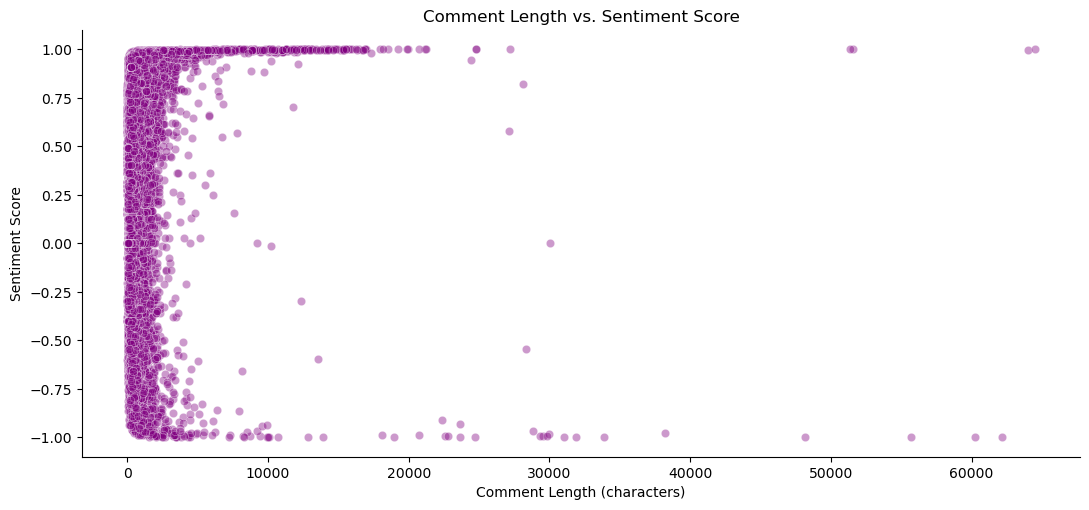

In [144]:
sns.relplot(data=comments,
            x='len',
            y='sent_score',
            color='purple',
            alpha=0.4,
            aspect=2.2).set(title='Comment Length vs. Sentiment Score',
                            xlabel='Comment Length (characters)',
                            ylabel='Sentiment Score');

Above I plotted comment length compared to sentiment score, to see if there was any indication of longer or shorter comments being more or less positive, but there appears to be no major relationship here.  The interesting observation here would be that the longest comments are either highly positive or negative and there aren't as many lengthy neutral comments.  This may also be why they were classified as neutral if there wasn't a lot of content to analyze.

### Channel Breakdown

In [145]:
comments['channel'].value_counts(normalize=True).mul(100).round(2)

web            62.73
email          34.49
mobile          1.95
system          0.71
api             0.11
help_center     0.01
Name: channel, dtype: float64

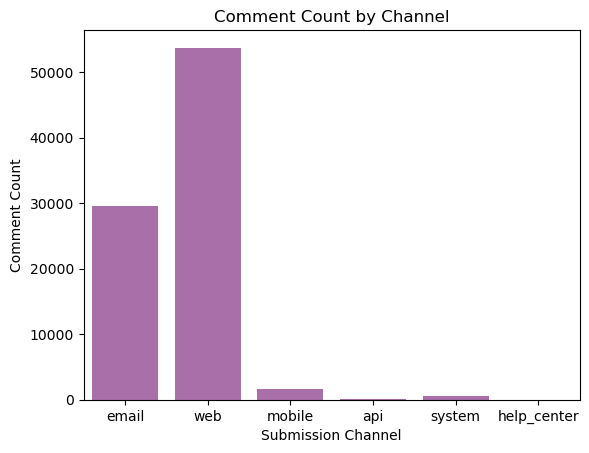

In [146]:
sns.countplot(x='channel', 
              data=comments,
              palette=['purple'],
              alpha=0.6
             ).set(title='Comment Count by Channel',
                   xlabel='Submission Channel',
                   ylabel='Comment Count'
);

From both the value counts, and the chart here, we can see that comments, like tickets, are created by web and email much more frequently than other channels.

In [147]:
(
    comments
    .groupby(['public'])
    ['channel']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
)

public  channel    
False   web            69.02
        email          22.69
        system          7.07
        mobile          0.72
        api             0.50
True    web            62.27
        email          35.35
        mobile          2.04
        system          0.25
        api             0.09
        help_center     0.01
Name: channel, dtype: float64

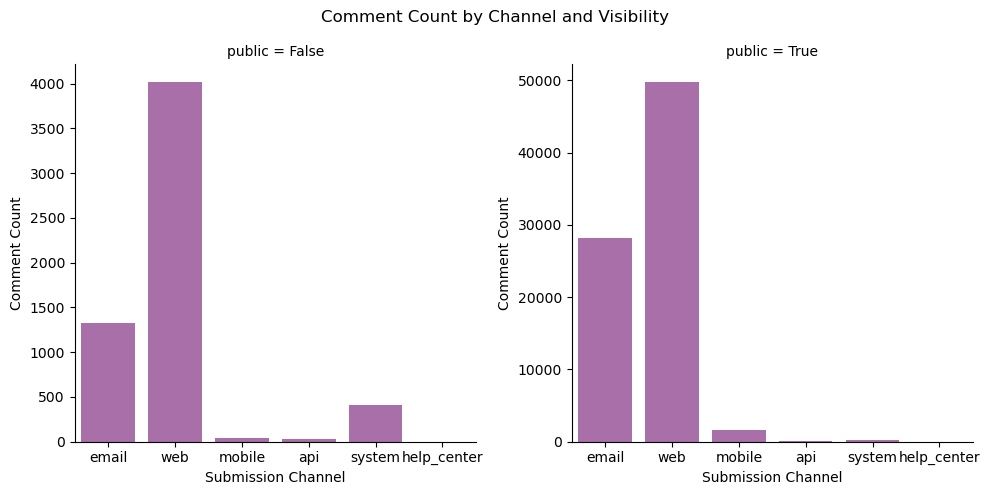

In [148]:
sns.catplot(data=comments,
            x='channel', 
            kind='count',
            col='public',
            palette=['purple'],
            alpha=0.6,
            sharey=False
             ).set(xlabel='Submission Channel',
                   ylabel='Comment Count'
)
plt.suptitle('Comment Count by Channel and Visibility')
plt.tight_layout();

In this plot and comparison, there are some observations:
* Web channel comments are the most common for both public and private comments
* For private comments, which are generally made by employees, have a higher proportion of web, which makes sense as these would be created when employees are working inside the Zendesk product
* System created comments tend to be internal, which also makes sense as those are likely messages indicating something like "ticket has been merged"

### Public / Private Breakdown

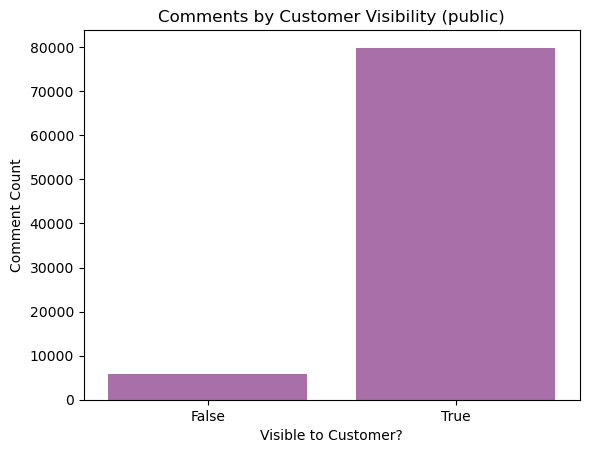

In [149]:
sns.countplot(data=comments,
              x='public',
              palette=['purple'],
              alpha=0.6,
             ).set(title='Comments by Customer Visibility (public)',
                   xlabel='Visible to Customer?',
                   ylabel='Comment Count'
);

Here we see that the overwhelming majority of the comments in the dataset are public-facing, meaning it was either authored by a customer, or authored as a public comment by an employee.

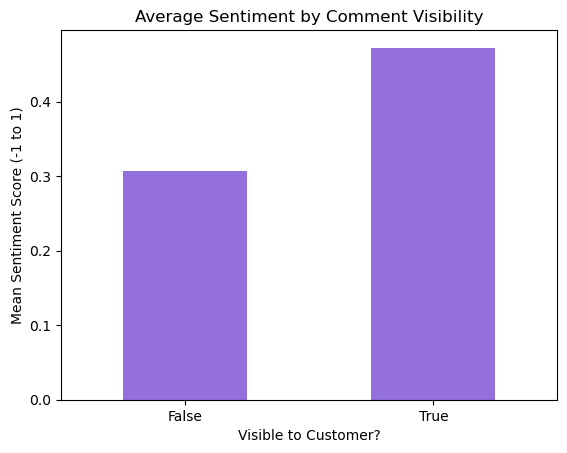

In [150]:
# average sentiment by comment public/private
(
    comments
    .groupby('public')
    ['sent_score']
    .mean()
    .plot(kind='bar',
          rot=0,
          color='mediumpurple',
          title='Average Sentiment by Comment Visibility',
          ylabel='Mean Sentiment Score (-1 to 1)',
          xlabel='Visible to Customer?'
         )
);

The above plot is looking across the entire comment dataset, over 85k comments, and comparing the mean sentiment score.  Here we can see that there is some difference in sentiment, but it isn't major since the sentiment scores range from -1 to 1, and the plot is only showing 0 to 0.5 on the y-axis.  This shows that even when employees are leaving internal comments on tickets, they are still using fairly positive language on the whole.  I may have suspected that the internal comment sentiment would be closer to neutral or even slightly negative, as those internal comments can often be used to "vent" or document an unvarnished opinion about what is transpiring in the ticket.

### Authors

* unique authors
* author frequency
* assuming highest frequency authors are prolific employees or customers, what is the avg sentinment comment by author (top 10)

The author of the comment will either be an external user or an internal employee.

In [151]:
# unique authors
comments['author_id'].nunique()

8897

There are almost 8900 unique authors in the comments from these rated tickets.  Since these tickets encompass such a large period of time (almost 7 years), I would have suspected this number to be higher.  This certainly isn't a representation of total unique individuals interacting with the ticketing system since this data was collected only looking at the rated tickets, which is why this is only a subset.

In [152]:
# Top 10 authors by public comment count, with mean comment sentiment score 
# and ticket length.
(
    comments
    .groupby('author_id')
    .agg({
        'public': 'count',
        'sent_score': 'mean', 
        'len': 'mean',
        'ticket_id': 'nunique'
    })
    .sort_values(by='public', ascending=False)
    .head(10)
)

,public,sent_score,len,ticket_id
author_id,,,,
10505752,8547,0.163864,440.924652,2771
494355454,7634,0.635119,853.418653,3286
55200513,5580,0.268450,316.951075,2204
370490441034,3907,0.766446,442.178142,1317
114109221013,2636,0.285475,504.605463,1011
114145132613,1650,0.696537,458.586667,809
368523033413,1361,0.622636,399.736958,481
9461431408,1091,0.553818,603.550871,387
4143323048,878,0.505162,425.013667,456


This information may be of use to management for employee feedback, with the assumption that these high volume commenters are employees, as there is a bit of variance in the mean sentiment scores across all the author's comments.  This doesn't imply good or bad, but might be useful to look into various communication styles or writing techniques between the authors.

Adding in the unique count of ticket IDs also shows an interesting picture.  For example, the author with the most comments has a sentiment score that isn't overly positive, and has lower average comment length and lower ticket count compared to the next author in the list.

Top 10 authors by 

In [153]:
# Top 10 authors by mean comment sentiment score, with public comment count,
# and comment length.
(
    comments
    .groupby('author_id')
    .agg({
        'sent_score': 'mean', 
        'public': 'count',
        'len': 'mean'
    })
    .sort_values(by='sent_score', ascending=False)
    .head(10)
)

,sent_score,public,len
author_id,,,
10239673436571,0.999900,1,10013.00
114096217973,0.999800,1,12548.00
408727686654,0.999700,1,13846.00
182803781,0.999575,4,7663.25
392518743293,0.999500,1,8725.00
379748122333,0.999500,1,8277.00
11115500333467,0.999400,1,14743.00
403173391053,0.999400,1,12047.00
1264005866949,0.999300,1,9154.00


This table shows the authors with the most positive sentiment, and we can see that they were (greater or less than) the average comment length, and also that they were mostly were from authors with a single comment.

## EDA Summary

Overall, throughout this data analysis, we saw most of the features of the data, especially the ticket data that is going to be used as the basis for modeling is not normally distributed, has high positive skews and long right tails.  Going forward in to modeling, I don't think that my original plan of a logistic regression model is appropriate, given that the assumption of linearity and normality is not met.  This means that in order to maintain one of the key goals of this project of inference, I believe my next best choice is a random forest model, so that is what I will focus on.

Other takeaways and high-level observations about this data:
* Over 85,000 comments and over 13,300 tickets were analyzed
* Class imbalance may be an issue for modeling
    * Overall, I think it is positive that the majority of the ticket ratings are 'good', but could provide a challenge
* Feature distributions
    * As mentioned above, the majority of the features are highly-skewed and non-normal, which is also a challenge for modeling
* Comment sentiment is overwhelming non-negative
    * The majority of the comments were classified as neutral or positive
* 31% of customers that rate tickets, leave an optional comment
    * of those, over 70% are from 'good' ratings


The average ticket in this data:
* Is submitted through the web form
* Stays to one internal group/team and one agent
* Has 3 replies to the customer and 4 comments total
* Is not re-opened after being solved
* First reply in 1380 minutes / 23 hours (calendar) 
* Resolution in 22182 minutes (calendar)
* Agent waits 5350 minutes (calendar)
* Request waits 16569 (calendar)

For modeling:
* There is some correlation between certain features, especially:
    * `replies` and `num_comms` (0.96)
    * `reqstr_wait_mins` and `full_reso_mins` (0.99)


Possible next steps to consider later on in this project, or possibly through another project:
* Collect data in order to separate out comments based on employee/agent or customer  
    * This would enable such things as sentiment analysis just on the customer's comments or just the employee or combined
* Get a list of common error messages from the business that might have a negative sentiment, or get a list of all error messages and try to remove those from the text during cleaning
* Collect data that would allow the ability to separate out the tickets by team
    * The data we are looking at is for all teams using Zendesk, which could have very different profiles--I think this might be the main reason we saw so many non-normal distributions.  Having tickets from teams that operate in similar manners may yield data that is more normally distributed